# Field Reversed Configuration (FRC) Simulations

The FRC formed through an RMF can be characterized by two important dimensionless parameters, $\lambda=R/\delta$, where $\delta=(2\eta /\mu_o \omega)^{1/2}$ is the classical skin depth, and by $\gamma=\omega_{ce}/\nu_{ei}$, where $\nu_{ei}=\eta(ne^2/m_e)$ is the electron-ion collision frequency. In term of the system parameters, these two parameters can be expressed as

$$ \lambda = R \left(\frac{\mu_o\omega}{2\eta}\right)^{1/2} $$,

$$ \gamma = \frac{1}{e}\left(\frac{B_\omega}{n\eta}\right) $$.

The magnitude of the external-driving field must exceed a certain critical value before much current is driven in the plasma column.

The measure of the current drive is the parameter $\alpha$, which is defined as the ratio of the driven current divided by the current obtained if all of the electrons rotate synchronously with the RMF.

$$ \alpha = \frac{2}{\mu_o n e \omega R^2}\left(B_z(r=R) - B(r=0) \right) $$

In [1]:
#######  IMPORTS ###########
import os
import re
#import vtk

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

#from vtk.util.numpy_support import vtk_to_numpy

# import pandas and seaborn
import pandas as pd
import seaborn as sns

# import keras functions
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

#import scikit-learn function
from sklearn.preprocessing import StandardScaler

/home/sousae/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def plot_regions_and_data(X, y, classifier,scaler,title):
    
    X_set, y_set = X, y
    X1, X2 = np.meshgrid(np.arange(start=X_set[:,0].min()-1, stop=X_set[:,0].max()+1, step=0.01),
                         np.arange(start=X_set[:,1].min()-1, stop=X_set[:,1].max()+1, step=0.01))
    
    Areas = classifier.predict_proba(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape)
    
    
    X1, X2 = np.meshgrid(np.arange(start=X_set[:,0].min()-1, stop=X_set[:,0].max()+1, step=0.01),
                         np.arange(start=X_set[:,1].min()-1, stop=X_set[:,1].max()+1, step=0.01))
    
    Xit = scaler.inverse_transform(np.array([X1.ravel(), X2.ravel()]).T)
    X1 = Xit[:,0].reshape(X1.shape)
    X2 = Xit[:,1].reshape(X2.shape)    
    
    plt.figure(figsize=(14,9))
    levels = np.linspace(0.,1.,21)
    sc = plt.contourf(X1,X2,Areas,levels, cmap='PiYG',origin='lower')
    plt.colorbar(sc, label='Probability of Reversal')
    
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())
    
    X_set = scaler.inverse_transform(X)
    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set==j, 0], X_set[y_set==j,1],
                    c=ListedColormap(('red','green'))(i), s=280, alpha=0.7)
    
    xx = np.linspace(X_set[:,0].min()-1,X_set[:,0].max()+1,1000)
    plt.plot(xx,gammaCritical(xx),'b--',lw=4.)
    
    plt.title(title)
    plt.xlabel(r"$\lambda = \frac{R}{\delta} = R\left(\frac{\mu_o\omega}{\eta}\right)^{1/2}$",fontsize=28)
    plt.ylabel(r"$\gamma = \frac{\omega_{ce}}{\nu_{ei}} = \frac{B_\omega}{en\eta}$",fontsize=28)
    plt.legend()

Text(7.5,12,'$\\gamma_c$')

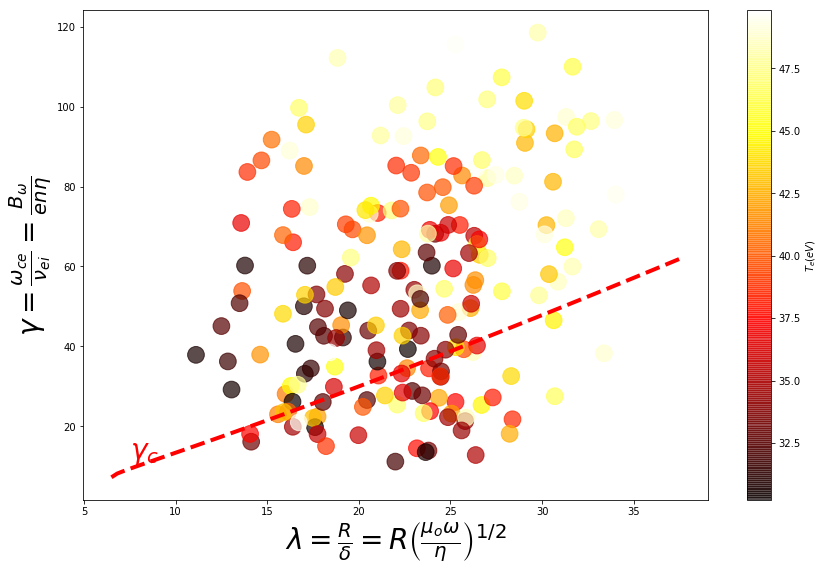

In [3]:
number = 200 # Sample size

def calRatio(w, Bw, Te):
    mu_o = np.pi*4.e-7
    e = 1.602e-19

    n = 1.0e20
    R = 0.03
    loglambda = 10.

    eta = 5.2e-5*loglambda/(Te)**1.5
    #eta = 1.65e-9*loglambda/(Te/1.e3)**1.5

    gamma = Bw/e/n/eta
    lmbda = R*np.sqrt(0.5*mu_o*w/eta)

    return gamma, lmbda

def gammaCritical(lbd):
    return 1.12*lbd*(1.0+0.12*(lbd-6.5)**0.4)

def getSelectionInRange(var, rmin, rmax, sample):
    a = np.where(var>rmin)
    b = np.where(var<rmax)
    intersec = np.intersect1d(a,b)

    if(sample<len(intersec)):
        randSample = np.random.randint(len(intersec), size=sample)
        res = intersec[randSample]
    else:
        res = intersec

    return res

omega = np.zeros(number)
Bomega= np.zeros(number)
Temp  = np.zeros(number)
lam   = np.zeros(number)
gam   = np.zeros(number)
gol   = np.zeros(number)

np.random.seed(4)
for k in range(number):
    omega[k] = np.random.uniform(2*np.pi*1.e5,2*np.pi*5.e5)
    Bomega[k]= np.random.uniform(5.e-4,30.e-4)
    Temp[k]  = np.random.uniform(30.,50.)
    gam[k], lam[k]   = calRatio(omega[k], Bomega[k], Temp[k])
    gol[k] = gam[k]/lam[k]

plt.figure(figsize=(14,9))
sc = plt.scatter(lam, gam, c=Temp, cmap="hot", alpha=0.7,s=280)

cb = plt.colorbar(sc, label=r'$T_e (eV)$')
#plt.legend()
plt.xlabel(r"$\lambda = \frac{R}{\delta} = R\left(\frac{\mu_o\omega}{\eta}\right)^{1/2}$",fontsize=28)
plt.ylabel(r"$\gamma = \frac{\omega_{ce}}{\nu_{ei}} = \frac{B_\omega}{en\eta}$",fontsize=28)
#plt.plot([0.2*pi,3.3],[1.,1.],'k--',lw=2.)
#plt.xlim(0.2*pi,3.3)

xx = np.linspace(6.5,37.5,100)
yy = gammaCritical(xx)
plt.plot(xx,yy,'r--',lw=4.)
plt.text(7.5,12.,r"$\gamma_c$",fontsize=28,color='red')

For each of the points in the scatter plot an Apollo simulations was run.

In [4]:
time = 51
component = 0

# get a list of all sub-directories in thedir
#thedir  = '/home/sousae/simulationsApollo/rmf_frc/dataAnalysis'
#subdirs = [ name for name in os.listdir(thedir) if os.path.isdir(os.path.join(thedir, name)) ]
#if '.ipynb_checkpoints' in subdirs: subdirs.remove('.ipynb_checkpoints') ### I get this weird sting in there somehow

frc = np.genfromtxt('frc_post_data.txt')    
    
#reader = vtk.vtkXMLUnstructuredGridReader()

# this function extracts the RMF frequency, RMF field magnitude, and the electron temperature at initialization
#def getSimulationParameters(filename):
#    f=open(filename)
#    lines = f.readlines()
#    om = re.findall("\d+\.\d+",lines[2])
#    Bo = re.findall("\d+\.\d+",lines[3])
#    Te = re.findall("\d+\.\d+",lines[4])
    
#    return float(om[0]), float(Bo[0]), float(Te[0])
    
#################### this is used to get the dimensions of the dataset per output file #####
#d = np.loadtxt(thedir+'/simulation_values.txt')
#folder = 'gammaOverGamma_crit_0.804947683677'
#filename = os.path.join(thedir,folder)+'/frc2d_2Fluid_000.vtu'
#reader = vtk.vtkXMLUnstructuredGridReader()
#reader.SetFileName(filename)
#reader.Update()
#size = len( vtk_to_numpy( reader.GetOutput().GetPointData().GetArray(component) ) )
############################################################################################

#dataB = np.zeros((size,time))
#dataR = np.zeros((size,time))
#minBz= np.zeros(time)

#frc = np.zeros((len(subdirs),12))

# Loop over all sample test cases
#for s in range(len(subdirs)):
    # get the values of omega, b_omega, and Te for this sample
#    frc[s,0], frc[s,1], frc[s,2] = getSimulationParameters(os.path.join(thedir,subdirs[s])+'/frc2d.pin')
    #calculate gamma, lambda and gamma/gammaCritical
#    frc[s,4], frc[s,3]   = calRatio(frc[s,0], frc[s,1], frc[s,2])
#    frc[s,5] = frc[s,4]/gammaCritical(frc[s,3])
    
    # loop over all time slices
#    for k in range(time):
#        filename = os.path.join(thedir,subdirs[s])+'/frc2d_2Fluid_'+str('%03d' % k)+'.vtu'
#        reader.SetFileName(filename)
#        reader.Update()
#        dataB[:,k] = vtk_to_numpy(reader.GetOutput().GetPointData().GetArray(15)) # Bz
#        dataR[:,k] = vtk_to_numpy(reader.GetOutput().GetPointData().GetArray(0)) # electron density
#        minBz[k]  = min(dataB[:,k])
        
    ### Do a SVD
#    U, sB, V = np.linalg.svd(dataB, full_matrices=False)
#    U, sR, V = np.linalg.svd(dataR, full_matrices=False)
    
    ### Get the first singular value for Bz SVD
#    frc[s,6] = sB[0]
#    frc[s,7] = sB[0]/sB.sum()
    
    ### Get the first singular value for rho_e SVD
#    frc[s,8] = sR[0]
#    frc[s,9] = sR[0]/sR.sum()
    
#    frc[s,10] = dataB.min()
#    frc[s,11] = (1. if dataB.min() < 0. else 0.)
#plt.figure(figsize=(14,9))
#plt.subplot(421), plt.plot(s/sum(s),'bo', markersize=12)
#plt.subplot(423), plt.plot(U[:,0],'b',lw=2)
#plt.subplot(425), plt.plot(U[:,1],'r',lw=2)
#plt.subplot(427), plt.plot(U[:,2],'g',lw=2)

#plt.subplot(422), plt.plot(minBz,lw=2)
#plt.subplot(422), plt.plot(plasmaFreqe,'r',lw=2)
#plt.subplot(422), plt.plot(plasmaFreqi,'g',lw=2)
#plt.subplot(422), plt.plot(plasmaFreqp,'m',lw=2)
#plt.subplot(424), plt.plot(V[0,:],'b',lw=2)
#plt.subplot(426), plt.plot(V[1,:],'r',lw=2)
#plt.subplot(428), plt.plot(V[2,:],'g',lw=2)
#np.savetxt(os.path.join(thedir,subdirs[s])+'/frc_testSamplesData.txt', frc)
print('Done.')

Done.


Text(7.5,12,'$\\gamma_c$')

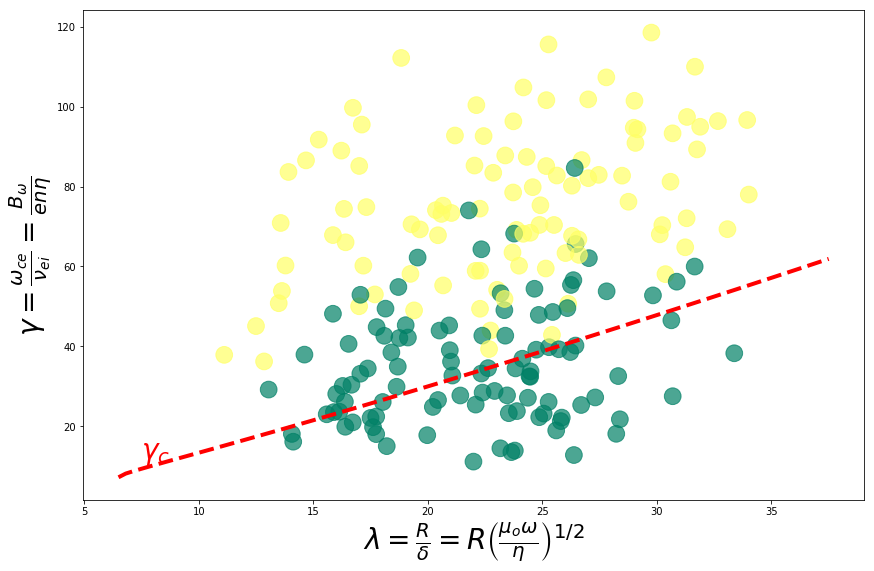

In [5]:
plt.figure(figsize=(14,9))
sc = plt.scatter(frc[:,3], frc[:,4], c=frc[:,11], cmap="summer", alpha=0.7,s=280)

#cb = plt.colorbar(sc, label=r'$B_z Reversal$')
#plt.legend()
plt.xlabel(r"$\lambda = \frac{R}{\delta} = R\left(\frac{\mu_o\omega}{\eta}\right)^{1/2}$",fontsize=28)
plt.ylabel(r"$\gamma = \frac{\omega_{ce}}{\nu_{ei}} = \frac{B_\omega}{en\eta}$",fontsize=28)
#plt.plot([0.2*pi,3.3],[1.,1.],'k--',lw=2.)
#plt.xlim(0.2*pi,3.3)

xx = np.linspace(6.5,37.5,100)
yy = gammaCritical(xx)
plt.plot(xx,yy,'r--',lw=4.)
plt.text(7.5,12.,r"$\gamma_c$",fontsize=28,color='red')

In [6]:
df = pd.DataFrame(frc, columns=['omega', 'Bomega', 'Te', 'lambda', 'gamma', 'gammaOverCrit', 'svd_bz', 
                                'svd_bz_per', 'svd_rho', 'svd_rho_perc', 'minBz', 'reversal'])

df["Bz_negative"] = df['reversal'].astype('category')

In [7]:
#fig, ax = plt.subplots(figsize=(14,9))
#sns.lmplot(x= 'lambda', y= 'gamma', data=df, hue='Bz_negative', palette='Set1', size=280)

The prediction pattern is complex, therefore a deep learning neural network will be developed in an attempt to predict the test cases reversal.

In [8]:
# setup need variables
predictors = frc[:,3:5]
target = to_categorical(frc[:,11])[:,1]


n_cols = predictors.shape[1]

# scale the predictors
scaler = StandardScaler()
scaler.fit(predictors)
predictors_scaled = scaler.transform(predictors)

def model_with_dropout(act, predict=predictors_scaled, targ=target, ncols=n_cols, drop=np.array([0.5, 0.5, 0.5])):
    model = Sequential()
    model.add(Dense(50, kernel_initializer='he_uniform', activation=act, input_shape = (ncols,)))
    model.add(Dropout(drop[0]))
    model.add(Dense(50, kernel_initializer='he_uniform', activation=act))
    model.add(Dropout(drop[1]))
    model.add(Dense(50, kernel_initializer='he_uniform', activation=act))
    model.add(Dropout(drop[2]))
    model.add(Dense(1, kernel_initializer='he_uniform', activation='sigmoid'))
    
    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # fit the model with early stopping
    early_stopping_monitor = EarlyStopping(patience=2)
    history = model.fit(predict, targ, validation_split=0.3, epochs=300)
    
    return history    

In [9]:
# create a model
activation = 'relu'

drop = np.array([0.4, 0.4, 0.4])
history = model_with_dropout(activation,drop=drop)

Train on 140 samples, validate on 60 samples
Epoch 1/300
140/140 [==============================] - 1s 6ms/step - loss: 1.1210 - acc: 0.5214 - val_loss: 0.4985 - val_acc: 0.7500
Epoch 2/300
140/140 [==============================] - 0s 2ms/step - loss: 0.8389 - acc: 0.6143 - val_loss: 0.4164 - val_acc: 0.9000
Epoch 3/300
140/140 [==============================] - 1s 4ms/step - loss: 0.9319 - acc: 0.5714 - val_loss: 0.3617 - val_acc: 0.9000
Epoch 4/300
140/140 [==============================] - 0s 996us/step - loss: 0.7030 - acc: 0.6357 - val_loss: 0.3295 - val_acc: 0.9000
Epoch 5/300
140/140 [==============================] - 0s 1ms/step - loss: 0.6834 - acc: 0.6929 - val_loss: 0.3081 - val_acc: 0.8833
Epoch 6/300
140/140 [==============================] - 0s 2ms/step - loss: 0.6919 - acc: 0.7071 - val_loss: 0.2886 - val_acc: 0.8833
Epoch 7/300
140/140 [==============================] - 0s 832us/step - loss: 0.8192 - acc: 0.6571 - val_loss: 0.2738 - val_acc: 0.9000
Epoch 8/300
140/140 

140/140 [==============================] - 0s 941us/step - loss: 0.4311 - acc: 0.7786 - val_loss: 0.2190 - val_acc: 0.9000
Epoch 62/300
140/140 [==============================] - 0s 308us/step - loss: 0.3977 - acc: 0.7929 - val_loss: 0.2197 - val_acc: 0.9000
Epoch 63/300
140/140 [==============================] - 0s 295us/step - loss: 0.3678 - acc: 0.8429 - val_loss: 0.2193 - val_acc: 0.9000
Epoch 64/300
140/140 [==============================] - 0s 310us/step - loss: 0.2937 - acc: 0.8571 - val_loss: 0.2202 - val_acc: 0.9000
Epoch 65/300
140/140 [==============================] - 0s 305us/step - loss: 0.3998 - acc: 0.8286 - val_loss: 0.2211 - val_acc: 0.9000
Epoch 66/300
140/140 [==============================] - 0s 297us/step - loss: 0.3814 - acc: 0.8143 - val_loss: 0.2210 - val_acc: 0.9000
Epoch 67/300
140/140 [==============================] - 0s 305us/step - loss: 0.3622 - acc: 0.8500 - val_loss: 0.2219 - val_acc: 0.9000
Epoch 68/300
140/140 [==============================] - 0s 29

140/140 [==============================] - 0s 252us/step - loss: 0.3147 - acc: 0.8571 - val_loss: 0.2500 - val_acc: 0.9000
Epoch 122/300
140/140 [==============================] - 0s 668us/step - loss: 0.3087 - acc: 0.8714 - val_loss: 0.2502 - val_acc: 0.9000
Epoch 123/300
140/140 [==============================] - 0s 202us/step - loss: 0.3564 - acc: 0.8214 - val_loss: 0.2502 - val_acc: 0.9000
Epoch 124/300
140/140 [==============================] - 0s 266us/step - loss: 0.3477 - acc: 0.8500 - val_loss: 0.2486 - val_acc: 0.9000
Epoch 125/300
140/140 [==============================] - 0s 293us/step - loss: 0.3827 - acc: 0.8643 - val_loss: 0.2471 - val_acc: 0.9000
Epoch 126/300
140/140 [==============================] - 0s 489us/step - loss: 0.3688 - acc: 0.8500 - val_loss: 0.2447 - val_acc: 0.9000
Epoch 127/300
140/140 [==============================] - 0s 342us/step - loss: 0.3521 - acc: 0.8500 - val_loss: 0.2445 - val_acc: 0.9000
Epoch 128/300
140/140 [==============================] 

140/140 [==============================] - 0s 427us/step - loss: 0.3215 - acc: 0.8500 - val_loss: 0.2539 - val_acc: 0.8833
Epoch 182/300
140/140 [==============================] - 0s 461us/step - loss: 0.2996 - acc: 0.8714 - val_loss: 0.2512 - val_acc: 0.8833
Epoch 183/300
140/140 [==============================] - 0s 640us/step - loss: 0.2906 - acc: 0.8714 - val_loss: 0.2501 - val_acc: 0.8833
Epoch 184/300
140/140 [==============================] - 0s 277us/step - loss: 0.3461 - acc: 0.8500 - val_loss: 0.2490 - val_acc: 0.8833
Epoch 185/300
140/140 [==============================] - 0s 366us/step - loss: 0.3117 - acc: 0.8500 - val_loss: 0.2483 - val_acc: 0.8833
Epoch 186/300
140/140 [==============================] - 0s 648us/step - loss: 0.3186 - acc: 0.8500 - val_loss: 0.2466 - val_acc: 0.8833
Epoch 187/300
140/140 [==============================] - 0s 1ms/step - loss: 0.3798 - acc: 0.8643 - val_loss: 0.2473 - val_acc: 0.8833
Epoch 188/300
140/140 [==============================] - 

140/140 [==============================] - 0s 794us/step - loss: 0.3449 - acc: 0.8571 - val_loss: 0.2659 - val_acc: 0.9000
Epoch 242/300
140/140 [==============================] - 0s 343us/step - loss: 0.3232 - acc: 0.8357 - val_loss: 0.2656 - val_acc: 0.9000
Epoch 243/300
140/140 [==============================] - 0s 318us/step - loss: 0.3241 - acc: 0.8643 - val_loss: 0.2668 - val_acc: 0.9000
Epoch 244/300
140/140 [==============================] - 0s 234us/step - loss: 0.2973 - acc: 0.8786 - val_loss: 0.2675 - val_acc: 0.9000
Epoch 245/300
140/140 [==============================] - 0s 453us/step - loss: 0.3129 - acc: 0.8429 - val_loss: 0.2698 - val_acc: 0.9000
Epoch 246/300
140/140 [==============================] - 1s 5ms/step - loss: 0.3048 - acc: 0.8429 - val_loss: 0.2699 - val_acc: 0.9000
Epoch 247/300
140/140 [==============================] - 0s 2ms/step - loss: 0.3024 - acc: 0.8786 - val_loss: 0.2694 - val_acc: 0.9000
Epoch 248/300
140/140 [==============================] - 0s

In [37]:
# create a new model
activation = 'linear'

history2 = model_with_dropout(activation,drop=drop)

Train on 140 samples, validate on 60 samples
Epoch 1/300
140/140 [==============================] - 1s 8ms/step - loss: 2.4630 - acc: 0.5286 - val_loss: 0.4602 - val_acc: 0.7833
Epoch 2/300
140/140 [==============================] - 0s 2ms/step - loss: 1.5760 - acc: 0.6571 - val_loss: 0.2193 - val_acc: 0.8667
Epoch 3/300
140/140 [==============================] - 0s 3ms/step - loss: 1.4581 - acc: 0.6714 - val_loss: 0.1671 - val_acc: 0.9167
Epoch 4/300
140/140 [==============================] - 0s 741us/step - loss: 1.3567 - acc: 0.7214 - val_loss: 0.1696 - val_acc: 0.9000
Epoch 5/300
140/140 [==============================] - 0s 407us/step - loss: 1.1956 - acc: 0.7929 - val_loss: 0.1743 - val_acc: 0.9167
Epoch 6/300
140/140 [==============================] - 0s 640us/step - loss: 0.9082 - acc: 0.8143 - val_loss: 0.1736 - val_acc: 0.9167
Epoch 7/300
140/140 [==============================] - 0s 2ms/step - loss: 1.1184 - acc: 0.8143 - val_loss: 0.1774 - val_acc: 0.9167
Epoch 8/300
140/14

140/140 [==============================] - 0s 421us/step - loss: 0.4586 - acc: 0.8071 - val_loss: 0.1727 - val_acc: 0.9167
Epoch 122/300
140/140 [==============================] - 0s 288us/step - loss: 0.4489 - acc: 0.8286 - val_loss: 0.1728 - val_acc: 0.9167
Epoch 123/300
140/140 [==============================] - 0s 240us/step - loss: 0.3799 - acc: 0.8143 - val_loss: 0.1728 - val_acc: 0.9167
Epoch 124/300
140/140 [==============================] - 0s 347us/step - loss: 0.4921 - acc: 0.7929 - val_loss: 0.1732 - val_acc: 0.9167
Epoch 125/300
140/140 [==============================] - 0s 366us/step - loss: 0.3991 - acc: 0.8571 - val_loss: 0.1740 - val_acc: 0.9167
Epoch 126/300
140/140 [==============================] - 0s 278us/step - loss: 0.4604 - acc: 0.8429 - val_loss: 0.1738 - val_acc: 0.9333
Epoch 127/300
140/140 [==============================] - 0s 648us/step - loss: 0.3865 - acc: 0.8214 - val_loss: 0.1745 - val_acc: 0.9333
Epoch 128/300
140/140 [==============================] 

140/140 [==============================] - 0s 707us/step - loss: 0.5106 - acc: 0.8429 - val_loss: 0.1822 - val_acc: 0.9333
Epoch 182/300
140/140 [==============================] - 0s 414us/step - loss: 0.3578 - acc: 0.8357 - val_loss: 0.1834 - val_acc: 0.9333
Epoch 183/300
140/140 [==============================] - 0s 883us/step - loss: 0.4165 - acc: 0.8429 - val_loss: 0.1836 - val_acc: 0.9333
Epoch 184/300
140/140 [==============================] - 0s 237us/step - loss: 0.3984 - acc: 0.8500 - val_loss: 0.1831 - val_acc: 0.9333
Epoch 185/300
140/140 [==============================] - 0s 694us/step - loss: 0.4089 - acc: 0.8143 - val_loss: 0.1823 - val_acc: 0.9333
Epoch 186/300
140/140 [==============================] - 0s 1ms/step - loss: 0.4597 - acc: 0.8214 - val_loss: 0.1812 - val_acc: 0.9333
Epoch 187/300
140/140 [==============================] - 0s 964us/step - loss: 0.3491 - acc: 0.8714 - val_loss: 0.1798 - val_acc: 0.9333
Epoch 188/300
140/140 [==============================] - 

Epoch 241/300
140/140 [==============================] - 0s 472us/step - loss: 0.3646 - acc: 0.8357 - val_loss: 0.1896 - val_acc: 0.9167
Epoch 242/300
140/140 [==============================] - 0s 479us/step - loss: 0.3626 - acc: 0.8643 - val_loss: 0.1922 - val_acc: 0.9167
Epoch 243/300
140/140 [==============================] - 0s 460us/step - loss: 0.4240 - acc: 0.8500 - val_loss: 0.1955 - val_acc: 0.9333
Epoch 244/300
140/140 [==============================] - 0s 464us/step - loss: 0.3801 - acc: 0.8429 - val_loss: 0.1961 - val_acc: 0.9333
Epoch 245/300
140/140 [==============================] - 0s 455us/step - loss: 0.3190 - acc: 0.8786 - val_loss: 0.1966 - val_acc: 0.9333
Epoch 246/300
140/140 [==============================] - 0s 436us/step - loss: 0.3212 - acc: 0.8929 - val_loss: 0.1959 - val_acc: 0.9333
Epoch 247/300
140/140 [==============================] - 0s 495us/step - loss: 0.3524 - acc: 0.8500 - val_loss: 0.1946 - val_acc: 0.9333
Epoch 248/300
140/140 [==================

In [38]:
activation = 'sigmoid'

history3 = model_with_dropout(activation,drop=drop)

Train on 140 samples, validate on 60 samples
Epoch 1/300
140/140 [==============================] - 1s 7ms/step - loss: 0.8626 - acc: 0.4643 - val_loss: 0.7003 - val_acc: 0.5667
Epoch 2/300
140/140 [==============================] - 0s 3ms/step - loss: 0.7930 - acc: 0.4929 - val_loss: 0.6706 - val_acc: 0.5667
Epoch 3/300
140/140 [==============================] - 0s 1ms/step - loss: 0.7172 - acc: 0.5429 - val_loss: 0.6618 - val_acc: 0.5667
Epoch 4/300
140/140 [==============================] - 0s 2ms/step - loss: 0.7454 - acc: 0.5214 - val_loss: 0.6672 - val_acc: 0.8500
Epoch 5/300
140/140 [==============================] - 0s 3ms/step - loss: 0.7680 - acc: 0.3857 - val_loss: 0.6745 - val_acc: 0.4333
Epoch 6/300
140/140 [==============================] - 0s 2ms/step - loss: 0.7247 - acc: 0.4857 - val_loss: 0.6781 - val_acc: 0.4333
Epoch 7/300
140/140 [==============================] - 0s 529us/step - loss: 0.6812 - acc: 0.5714 - val_loss: 0.6722 - val_acc: 0.4333
Epoch 8/300
140/140 [=

140/140 [==============================] - 0s 487us/step - loss: 0.3900 - acc: 0.8214 - val_loss: 0.2036 - val_acc: 0.9167
Epoch 122/300
140/140 [==============================] - 0s 465us/step - loss: 0.3867 - acc: 0.8571 - val_loss: 0.2013 - val_acc: 0.9167
Epoch 123/300
140/140 [==============================] - 0s 790us/step - loss: 0.3840 - acc: 0.8286 - val_loss: 0.2016 - val_acc: 0.9167
Epoch 124/300
140/140 [==============================] - 0s 1ms/step - loss: 0.3620 - acc: 0.8643 - val_loss: 0.2002 - val_acc: 0.9167
Epoch 125/300
140/140 [==============================] - 0s 778us/step - loss: 0.3791 - acc: 0.8429 - val_loss: 0.2010 - val_acc: 0.9167
Epoch 126/300
140/140 [==============================] - 0s 429us/step - loss: 0.3873 - acc: 0.8643 - val_loss: 0.2034 - val_acc: 0.9167
Epoch 127/300
140/140 [==============================] - 0s 949us/step - loss: 0.3806 - acc: 0.8500 - val_loss: 0.2047 - val_acc: 0.9167
Epoch 128/300
140/140 [==============================] - 

140/140 [==============================] - 0s 310us/step - loss: 0.4202 - acc: 0.8286 - val_loss: 0.2000 - val_acc: 0.9333
Epoch 182/300
140/140 [==============================] - 0s 641us/step - loss: 0.3838 - acc: 0.8571 - val_loss: 0.1985 - val_acc: 0.9167
Epoch 183/300
140/140 [==============================] - 0s 907us/step - loss: 0.3488 - acc: 0.8429 - val_loss: 0.1985 - val_acc: 0.9167
Epoch 184/300
140/140 [==============================] - 0s 568us/step - loss: 0.3491 - acc: 0.8429 - val_loss: 0.1989 - val_acc: 0.9167
Epoch 185/300
140/140 [==============================] - 0s 675us/step - loss: 0.3247 - acc: 0.8714 - val_loss: 0.1995 - val_acc: 0.9167
Epoch 186/300
140/140 [==============================] - 0s 2ms/step - loss: 0.3618 - acc: 0.8357 - val_loss: 0.2003 - val_acc: 0.9333
Epoch 187/300
140/140 [==============================] - 0s 2ms/step - loss: 0.3826 - acc: 0.8714 - val_loss: 0.2020 - val_acc: 0.9333
Epoch 188/300
140/140 [==============================] - 0s

Epoch 241/300
140/140 [==============================] - 0s 285us/step - loss: 0.3359 - acc: 0.8643 - val_loss: 0.2046 - val_acc: 0.9333
Epoch 242/300
140/140 [==============================] - 0s 270us/step - loss: 0.3679 - acc: 0.8429 - val_loss: 0.2040 - val_acc: 0.9333
Epoch 243/300
140/140 [==============================] - 0s 280us/step - loss: 0.3362 - acc: 0.8714 - val_loss: 0.2038 - val_acc: 0.9333
Epoch 244/300
140/140 [==============================] - 0s 1ms/step - loss: 0.3869 - acc: 0.8429 - val_loss: 0.2016 - val_acc: 0.9167
Epoch 245/300
140/140 [==============================] - 0s 845us/step - loss: 0.3377 - acc: 0.8357 - val_loss: 0.1987 - val_acc: 0.9167
Epoch 246/300
140/140 [==============================] - 0s 273us/step - loss: 0.4090 - acc: 0.8286 - val_loss: 0.1992 - val_acc: 0.9167
Epoch 247/300
140/140 [==============================] - 0s 426us/step - loss: 0.4004 - acc: 0.8357 - val_loss: 0.2016 - val_acc: 0.9167
Epoch 248/300
140/140 [====================

In [39]:
activation = 'tanh'

history4 = model_with_dropout(activation,drop=drop)

Train on 140 samples, validate on 60 samples
Epoch 1/300
140/140 [==============================] - 1s 7ms/step - loss: 0.5777 - acc: 0.7143 - val_loss: 0.2736 - val_acc: 0.9000
Epoch 2/300
140/140 [==============================] - 0s 3ms/step - loss: 0.5121 - acc: 0.7571 - val_loss: 0.2450 - val_acc: 0.9000
Epoch 3/300
140/140 [==============================] - 0s 3ms/step - loss: 0.4956 - acc: 0.7857 - val_loss: 0.2349 - val_acc: 0.9000
Epoch 4/300
140/140 [==============================] - 0s 1ms/step - loss: 0.4343 - acc: 0.8286 - val_loss: 0.2314 - val_acc: 0.9000
Epoch 5/300
140/140 [==============================] - 0s 1ms/step - loss: 0.4373 - acc: 0.8071 - val_loss: 0.2311 - val_acc: 0.9000
Epoch 6/300
140/140 [==============================] - 0s 675us/step - loss: 0.4549 - acc: 0.8071 - val_loss: 0.2261 - val_acc: 0.9000
Epoch 7/300
140/140 [==============================] - 0s 577us/step - loss: 0.4884 - acc: 0.8429 - val_loss: 0.2235 - val_acc: 0.9000
Epoch 8/300
140/140 

140/140 [==============================] - 0s 472us/step - loss: 0.3565 - acc: 0.8429 - val_loss: 0.1983 - val_acc: 0.9167
Epoch 122/300
140/140 [==============================] - 0s 543us/step - loss: 0.3754 - acc: 0.8857 - val_loss: 0.1980 - val_acc: 0.9167
Epoch 123/300
140/140 [==============================] - 0s 965us/step - loss: 0.3721 - acc: 0.8500 - val_loss: 0.1986 - val_acc: 0.9167
Epoch 124/300
140/140 [==============================] - 1s 4ms/step - loss: 0.3829 - acc: 0.8500 - val_loss: 0.1991 - val_acc: 0.9167
Epoch 125/300
140/140 [==============================] - 0s 2ms/step - loss: 0.3780 - acc: 0.8571 - val_loss: 0.1996 - val_acc: 0.9167
Epoch 126/300
140/140 [==============================] - 0s 305us/step - loss: 0.3981 - acc: 0.8571 - val_loss: 0.2000 - val_acc: 0.9167
Epoch 127/300
140/140 [==============================] - 0s 1ms/step - loss: 0.3683 - acc: 0.8429 - val_loss: 0.2002 - val_acc: 0.9167
Epoch 128/300
140/140 [==============================] - 0s 7

140/140 [==============================] - 0s 947us/step - loss: 0.3418 - acc: 0.8643 - val_loss: 0.1963 - val_acc: 0.9167
Epoch 242/300
140/140 [==============================] - 0s 1ms/step - loss: 0.3428 - acc: 0.9000 - val_loss: 0.1966 - val_acc: 0.9167
Epoch 243/300
140/140 [==============================] - 0s 558us/step - loss: 0.3571 - acc: 0.8500 - val_loss: 0.1967 - val_acc: 0.9167
Epoch 244/300
140/140 [==============================] - 0s 1ms/step - loss: 0.3515 - acc: 0.8643 - val_loss: 0.1969 - val_acc: 0.9167
Epoch 245/300
140/140 [==============================] - 0s 391us/step - loss: 0.3409 - acc: 0.8857 - val_loss: 0.1972 - val_acc: 0.9167
Epoch 246/300
140/140 [==============================] - 0s 430us/step - loss: 0.3436 - acc: 0.8714 - val_loss: 0.1974 - val_acc: 0.9167
Epoch 247/300
140/140 [==============================] - 0s 388us/step - loss: 0.3131 - acc: 0.8714 - val_loss: 0.1969 - val_acc: 0.9167
Epoch 248/300
140/140 [==============================] - 0s

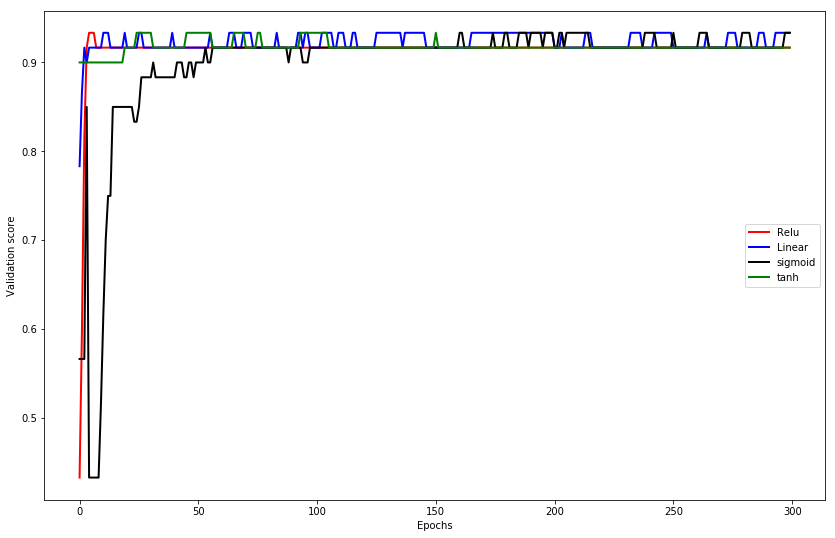

In [40]:
# Create the plot
plt.figure(figsize=(14,9))
plt.plot(history.history['val_acc'], 'r', label='Relu', lw=2, markersize=20)
plt.plot(history2.history['val_acc'], 'b', label='Linear', lw=2, markersize=20)
plt.plot(history3.history['val_acc'], 'k', label='sigmoid', lw=2, markersize=20)
plt.plot(history4.history['val_acc'], 'g', label='tanh', lw=2, markersize=20)
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.legend(loc='center right')
plt.savefig("deepLearningFRC1.png",dpi=300)

In [17]:
ann_relu = Sequential()
ann_relu.add(Dense(50, init = 'uniform', activation='relu', input_shape = (2,)))
ann_relu.add(Dense(50, init = 'uniform', activation='relu'))
ann_relu.add(Dense(50, init = 'uniform', activation='relu'))
ann_relu.add(Dense(1, init = 'uniform', activation='sigmoid'))
    
# compile the model
ann_relu.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
# fit the model with early stopping
early_stopping_monitor = EarlyStopping(patience=2)
history = ann_relu.fit(predictors_scaled, target, validation_split=0.25, epochs=30,
                    callbacks = [early_stopping_monitor])

/home/sousae/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(50, activation="relu", input_shape=(2,), kernel_initializer="uniform")`
  
/home/sousae/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(50, activation="relu", kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/sousae/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(50, activation="relu", kernel_initializer="uniform")`
  after removing the cwd from sys.path.
/home/sousae/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  """


Train on 150 samples, validate on 50 samples
Epoch 1/30
150/150 [==============================] - 1s 6ms/step - loss: 0.6931 - acc: 0.4400 - val_loss: 0.6927 - val_acc: 0.7800
Epoch 2/30
150/150 [==============================] - 0s 2ms/step - loss: 0.6926 - acc: 0.8000 - val_loss: 0.6920 - val_acc: 0.9000
Epoch 3/30
150/150 [==============================] - 1s 3ms/step - loss: 0.6918 - acc: 0.8200 - val_loss: 0.6903 - val_acc: 0.9200
Epoch 4/30
150/150 [==============================] - 1s 4ms/step - loss: 0.6899 - acc: 0.8467 - val_loss: 0.6870 - val_acc: 0.9200
Epoch 5/30
150/150 [==============================] - 0s 2ms/step - loss: 0.6866 - acc: 0.8400 - val_loss: 0.6816 - val_acc: 0.9200
Epoch 6/30
150/150 [==============================] - 0s 1ms/step - loss: 0.6811 - acc: 0.8467 - val_loss: 0.6726 - val_acc: 0.9000
Epoch 7/30
150/150 [==============================] - 0s 1ms/step - loss: 0.6726 - acc: 0.8667 - val_loss: 0.6583 - val_acc: 0.9200
Epoch 8/30
150/150 [===========

In [18]:
X_set, y_set = predictors_scaled, target
X1, X2 = np.meshgrid(np.arange(start=X_set[:,0].min()-1, stop=X_set[:,0].max()+1, step=0.01),
                     np.arange(start=X_set[:,1].min()-1, stop=X_set[:,1].max()+1, step=0.01))

In [19]:
Areas = ann_relu.predict_proba(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape)

In [20]:
X1, X2 = np.meshgrid(np.arange(start=X_set[:,0].min()-1, stop=X_set[:,0].max()+1, step=0.01),
                     np.arange(start=X_set[:,1].min()-1, stop=X_set[:,1].max()+1, step=0.01))

Xit = scaler.inverse_transform(np.array([X1.ravel(), X2.ravel()]).T)
X1 = Xit[:,0].reshape(X1.shape)
X2 = Xit[:,1].reshape(X2.shape)

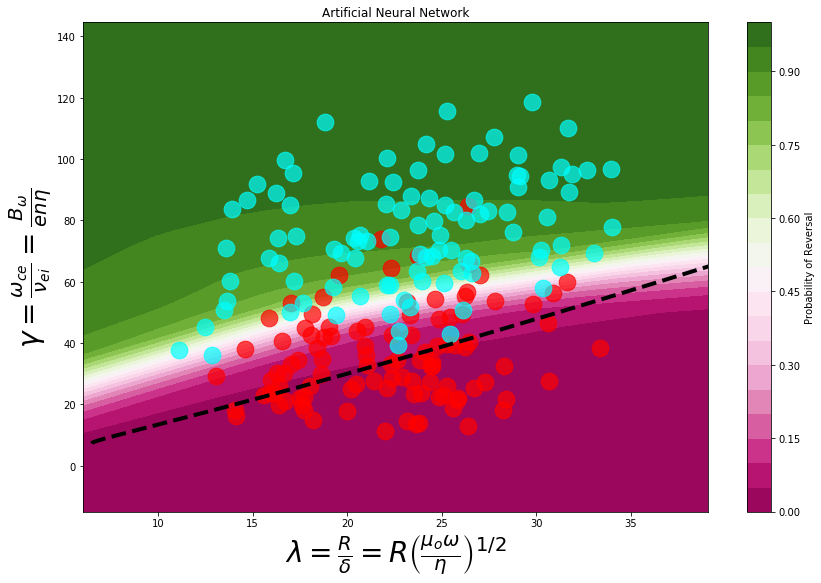

In [22]:
plt.figure(figsize=(14,9))
levels = np.linspace(0.,1.,21)
sc = plt.contourf(X1,X2,Areas,levels, cmap='PiYG',origin='lower')
plt.colorbar(sc, label='Probability of Reversal')
    
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

X_set = scaler.inverse_transform(predictors_scaled)
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set==j, 0], X_set[y_set==j,1],
                c=ListedColormap(('red','cyan'))(i), s=280, alpha=0.7)
    
#xx = np.linspace(X_set[:,0].min()-1,X_set[:,0].max()+1,1000)
xx = np.linspace(6.5, 40., 1000)
plt.plot(xx,gammaCritical(xx),'k--',lw=4.)

plt.title("Artificial Neural Network")
plt.xlabel(r"$\lambda = \frac{R}{\delta} = R\left(\frac{\mu_o\omega}{\eta}\right)^{1/2}$",fontsize=28)
plt.ylabel(r"$\gamma = \frac{\omega_{ce}}{\nu_{ei}} = \frac{B_\omega}{en\eta}$",fontsize=28)
#plt.legend()
plt.savefig("deepLearningFRC2.png",dpi=300)

In [11]:
Above=df[df['gammaOverCrit']>1]

In [12]:
Above.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 199
Data columns (total 13 columns):
omega            150 non-null float64
Bomega           150 non-null float64
Te               150 non-null float64
lambda           150 non-null float64
gamma            150 non-null float64
gammaOverCrit    150 non-null float64
svd_bz           150 non-null float64
svd_bz_per       150 non-null float64
svd_rho          150 non-null float64
svd_rho_perc     150 non-null float64
minBz            150 non-null float64
reversal         150 non-null float64
Bz_negative      150 non-null category
dtypes: category(1), float64(12)
memory usage: 15.5 KB


In [13]:
new=Above[Above['reversal']==1]

In [14]:
new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98 entries, 0 to 197
Data columns (total 13 columns):
omega            98 non-null float64
Bomega           98 non-null float64
Te               98 non-null float64
lambda           98 non-null float64
gamma            98 non-null float64
gammaOverCrit    98 non-null float64
svd_bz           98 non-null float64
svd_bz_per       98 non-null float64
svd_rho          98 non-null float64
svd_rho_perc     98 non-null float64
minBz            98 non-null float64
reversal         98 non-null float64
Bz_negative      98 non-null category
dtypes: category(1), float64(12)
memory usage: 10.1 KB


In [15]:
98./150.

0.6533333333333333